In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *

In [3]:
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [4]:
imgs_path = "../src/imgs"

# Helper functions

In [5]:
def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points





def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]


def combine_datasets(algorithm_name, log_data_path):
    simulations = []
    for dataset_name in ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1", "UK75_3", "UK75_6"]:
        try:
            simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
        except:
            print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
        if dataset_name == "UK25_2":
            try:
                simulation = remove_unwanted_mutation_parameter_groups(simulation)
                if algorithm_name == "SA":
                    simulation["Parameter Group"] = simulation["Parameter Group"]/2
                else:
                    simulation["Parameter Group"] = sorted(list(range(45)) * 30)
            except:
                #print("No parameter groups to alter.")
                pass
        simulation["dataset"] = dataset_name
        simulations.append(simulation)
    
    for df in simulations:
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
    return pd.concat(simulations)


def plot_3d_minmax(datapoints, labels, marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    
    plt.style.use("../src/style/custom-seaborn-3dplot.mplstyle")
    fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
    for data, label in zip(datapoints, labels):

        #fuel_consumptions = np.array(data.fuel_consumption_final)#np.array( [x[0] for x in data.fitness_final])
        #drive_times = data.vehicle_route_time
        #compute_times = np.array(data.optimal_time)
        
        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
        mean_f1,min_f1,max_f1 =  data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max
        mean_f2,min_f2,max_f2 =  data.computation_times_final_mean, data.computation_times_final_min, data.computation_times_final_max
        
        #print(mean_f1,min_f1,max_f1)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
        plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=mean_f2, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        # ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2,color=sns.color_palette("deep",10)[1])
    return fig, ax


def plot_3d_minmax_scaled(datapoints, labels, marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    
    plt.style.use("../src/style/custom-seaborn-3dplot.mplstyle")
    fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
    for data, label in zip(datapoints, labels):

        #fuel_consumptions = np.array(data.fuel_consumption_final)#np.array( [x[0] for x in data.fitness_final])
        #drive_times = data.vehicle_route_time
        #compute_times = np.array(data.optimal_time)
        
        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
        mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        mean_f2,min_f2,max_f2 =  data.computation_times_final_mean, data.computation_times_final_min, data.computation_times_final_max
        
        #print(mean_f1,min_f1,max_f1)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
        plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=mean_f2, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        # ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2,color=sns.color_palette("deep",10)[1])
    return fig, ax


In [6]:
def add_minmax_fuel_drivetime_columns(dataframes):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    for dataframe in dataframes:
        datasets = dataframe.dataset.unique()
        for dataset in datasets:
            if not dataset in max_fuel_consumptions.keys():
                max_fuel_consumptions[dataset] = 0
                min_fuel_consumptions[dataset]  = 10e10
                max_drivetimes[dataset]  = 0
                min_drivetimes[dataset]  = 10e10
            
            
            
            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()
            
            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()
            
            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel
                
            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel
                
            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime
                
            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
                
    
    for dataframe in dataframes:
        datasets = dataframe.dataset.unique()
        for dataset in datasets:
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = (dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)

            dataframe['fuel_consumption_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_fuel_consumption_scaled,dataframe.fuel_consumption_final_minmax)
            
            dataframe_longest_drivetime_scaled = (dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
            dataframe['longest_route_time_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_longest_drivetime_scaled,dataframe.longest_route_time_final_minmax)
      
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.fuel_consumption_final_minmax)
        dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
        dataframe["fuel_consumption_final_minmax_min"] = min_f0
        dataframe["fuel_consumption_final_minmax_max"] = max_f0

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.longest_route_time_final_minmax)
        dataframe["longest_route_time_final_minmax_mean"] = mean_f0
        dataframe["longest_route_time_final_minmax_min"] = min_f0
        dataframe["longest_route_time_final_minmax_max"] = max_f0
        

In [302]:
import time 
start_time = time.monotonic()
print("SA")
SA_data = combine_datasets("SA", "parameter_data/")
SA_data = SA_data.where(SA_data["Parameter Group"] == 4).dropna()
print("GA")
GA_data = combine_datasets("GA", "parameter_data/")
GA_data = GA_data.where(GA_data["Parameter Group"] == 38).dropna()
print("NSGA2")
NSGA2_data = combine_datasets("NSGA2", "parameter_data/")
NSGA2_data = NSGA2_data.where(NSGA2_data["Parameter Group"] == 41).dropna()
print("NSGA3")
NSGA3_data = combine_datasets("NSGA3", "parameter_data/")
NSGA3_data = NSGA3_data.where(NSGA3_data["Parameter Group"] == 40).dropna()
print("UNSGA3")
UNSGA3_data = combine_datasets("UNSGA3", "parameter_data/")
UNSGA3_data = UNSGA3_data.where(UNSGA3_data["Parameter Group"] == 37).dropna()
print("IBEA")
IBEA_data = combine_datasets("IBEA", "parameter_data/")
IBEA_data = IBEA_data.where(IBEA_data["Parameter Group"] == 43).dropna()

print("Time: ", time.monotonic() - start_time)

Time:  113.07026252099968


In [7]:
import time 
start_time = time.monotonic()
print("SA")
SA_data_evaluation_limited = combine_datasets("SA", "parameter_data/")
SA_data_evaluation_limited = SA_data_evaluation_limited.where(SA_data_evaluation_limited["Parameter Group"] == 4).dropna().mean()
print("GA")
GA_data_evaluation_limited = combine_datasets("GA", "parameter_data/")
GA_data_evaluation_limited2 = GA_data_evaluation_limited.where(GA_data_evaluation_limited["Parameter Group"] == 38).dropna()
GA_data_evaluation_limited = GA_data_evaluation_limited.where(GA_data_evaluation_limited["Parameter Group"] == 38).dropna().mean()

print("NSGA2")
NSGA2_data_evaluation_limited = combine_datasets("NSGA2", "parameter_data/reruns/").mean()
print("NSGA3")
NSGA3_data_evaluation_limited = combine_datasets("NSGA3", "parameter_data/reruns/").mean()
print("UNSGA3")
UNSGA3_data_evaluation_limited = combine_datasets("UNSGA3", "parameter_data/reruns/").mean()
print("IBEA")
IBEA_data_evaluation_limited = combine_datasets("IBEA", "parameter_data/reruns/").mean()

print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  28.94051258499894


In [303]:
add_minmax_fuel_drivetime_columns([SA_data,GA_data,NSGA2_data,NSGA3_data,UNSGA3_data,IBEA_data])

In [304]:
SA_data

,Unnamed: 0,fitness,route_distance,fuel_consumption,vehicle_loads,computation_times,vehicle_route_time,violation,paths,Parameter Group,...,longest_route_time_final_minmax_min,longest_route_time_final_minmax_max,computation_times_final_mean,computation_times_final_min,computation_times_final_max,computation_times_final_minmax,distance_to_origin_mean,distance_to_origin_min,distance_to_origin_max,distance_to_origin_minmax
240,0.0,"[255.7789750715275, 249.32285831567845, 249.32...","[122371, 40777, 135302, 113277, 82874]","[93.51230840486082, 87.05619164901177, 87.0561...","[array([ 0., 766., 649., 478., 816., 227.]), ...","[0.005902767181396484, 0.01199960708618164, 0....","[9095, 3946, 7792, 8539, 6674]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[['V0', 14, 9, 13, 7, 23, 22], ['V3', 11, 25, ...",4.0,...,0.102012,0.14161,0.703642,0.574137,0.833146,0.100633,168.392495,166.544373,170.240618,0.184601
241,1.0,"[367.1694478972795, 367.1694478972795, 367.169...","[115831, 106117, 135302, 106528, 40777, 82874]","[103.2694478972795, 103.2694478972795, 103.269...","[array([ 0., 766., 649., 227.]), array([ 0.,...","[0.00632929801940918, 0.012946128845214844, 0....","[7715, 7708, 7792, 7530, 3946, 6674]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[['V0', 14, 9, 23, 22], ['V1', 13, 7, 24, 3, 2...",4.0,...,0.102012,0.14161,0.703642,0.574137,0.833146,0.091833,168.392495,166.544373,170.240618,0.055937
242,2.0,"[298.43603858209866, 298.43603858209866, 294.3...","[113303, 138042, 128266, 75310, 98083]","[105.10270524876532, 105.10270524876532, 100.9...","[array([ 0., 766., 649., 816., 478.]), array(...","[0.006307125091552734, 0.013045549392700195, 0...","[7999, 8748, 8542, 6042, 7892]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[['V1', 14, 9, 7, 13, 2], ['V0', 19, 23, 22], ...",4.0,...,0.102012,0.14161,0.703642,0.574137,0.833146,0.037294,168.392495,166.544373,170.240618,0.181723
243,3.0,"[267.5289161249423, 261.3723480984969, 260.266...","[29543, 117875, 58219, 135302, 115491, 98083]","[91.47891612494232, 88.67234809849688, 87.5665...","[array([322., 234.]), array([ 0., 766., 649.,...","[0.005795478820800781, 0.011953353881835938, 0...","[2618, 8103, 4480, 7792, 8114, 7892]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[['V3', 11, 2], ['V0', 14, 9, 7, 23, 22], ['V2...",4.0,...,0.102012,0.14161,0.703642,0.574137,0.833146,0.048780,168.392495,166.544373,170.240618,0.076135
244,4.0,"[312.65605416717153, 311.1868838961405, 311.18...","[117875, 121200, 137591, 61595, 82874]","[115.97272083383822, 114.50355056280715, 114.5...","[array([ 0., 766., 649., 816., 227.]), array(...","[0.0066792964935302734, 0.013265609741210938, ...","[8103, 8441, 7993, 5558, 6674]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[['V0', 14, 9, 7, 23, 22], ['V4', 21, 1, 24, 1...",4.0,...,0.102012,0.14161,0.703642,0.574137,0.833146,0.092467,168.392495,166.544373,170.240618,0.092533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,25.0,"[3126.22048103201, 3126.22048103201, 3126.2204...","[100752, 95547, 87654, 187588, 226770, 174107,...","[340.6538143653435, 340.6538143653435, 340.653...","[array([662., 577., 788., 761.]), array([184.,...","[0.016869068145751953, 0.03346848487854004, 0....","[8191, 5978, 5566, 14619, 15688, 16347, 6196, ...","[-2278.0, -2278.0, -2278.0, -624.0, -624.0, -6...","[['V14', 28, 8, 14, 32], ['V12', 22, 72, 45], ...",4.0,...,0.102012,0.14161,5.972162,5.403358,6.540965,0.098734,473.306058,468.998685,477.613431,0.153935
146,26.0,"[3126.22048103201, 3126.22048103201, 1453.6112...","[132980, 57768, 134563, 242122, 110164, 100300...","[340.6538143653435, 340.6538143653435, 487.911...","[array([ 0., 268., 788., 577., 823., 737.]), ...","[0.016566991806030273, 0.03576374053955078, 0....","[11115, 3732, 14556, 17610, 8114, 7086, 14600,...","[-2278.0, -2278.0, -624.0, -624.0, -624.0, -62...","[['V0', 64, 8, 28, 50, 46, 5], ['V1', 37, 32],...",4.0,...,0.102012,0.14161,5.9721

# SASA_data

Unnamed: 0                               14.500000
Parameter Group                           4.000000
fuel_consumption_final                  230.408973
longest_route_time_final                267.017593
mutation                                  0.900000
distance_to_origin                      355.700610
computation_times_final                   2.591798
fuel_consumption_final_mean             239.723094
fuel_consumption_final_min              236.827126
fuel_consumption_final_max              242.619062
fuel_consumption_final_minmax             0.334297
fuel_consumption_final_minmax_mean        0.334297
fuel_consumption_final_minmax_min         0.311647
fuel_consumption_final_minmax_max         0.356946
longest_route_time_final_mean           271.784235
longest_route_time_final_min            269.391793
longest_route_time_final_max            274.176676
longest_route_time_final_minmax           0.121811
longest_route_time_final_minmax_mean      0.121811
longest_route_time_final_minmax

In [308]:
SA_best = SA_data.mean()

In [161]:
SA_best

Unnamed: 0                               14.500000
fuel_consumption_final                  230.408973
longest_route_time_final                267.017593
mutation                                  0.900000
distance_to_origin                      355.700610
computation_times_final                   2.591798
fuel_consumption_final_mean             239.723094
fuel_consumption_final_min              236.827126
fuel_consumption_final_max              242.619062
fuel_consumption_final_minmax             0.242115
fuel_consumption_final_minmax_mean        0.312596
fuel_consumption_final_minmax_min         0.280670
fuel_consumption_final_minmax_max         0.344521
longest_route_time_final_mean           271.784235
longest_route_time_final_min            269.391793
longest_route_time_final_max            274.176676
longest_route_time_final_minmax           0.168575
longest_route_time_final_minmax_mean      0.232150
longest_route_time_final_minmax_min       0.199384
longest_route_time_final_minmax

# GA

In [309]:
GA_best = GA_data.mean()

# NSGA-II

In [310]:
NSGA2_best = NSGA2_data.mean()

# NSGA-III

In [311]:
NSGA3_best = NSGA3_data.mean()

# U-NSGA-III

In [312]:
UNSGA3_best = UNSGA3_data.mean()

# IBEA

In [313]:
IBEA_best = IBEA_data.mean()

# Plot

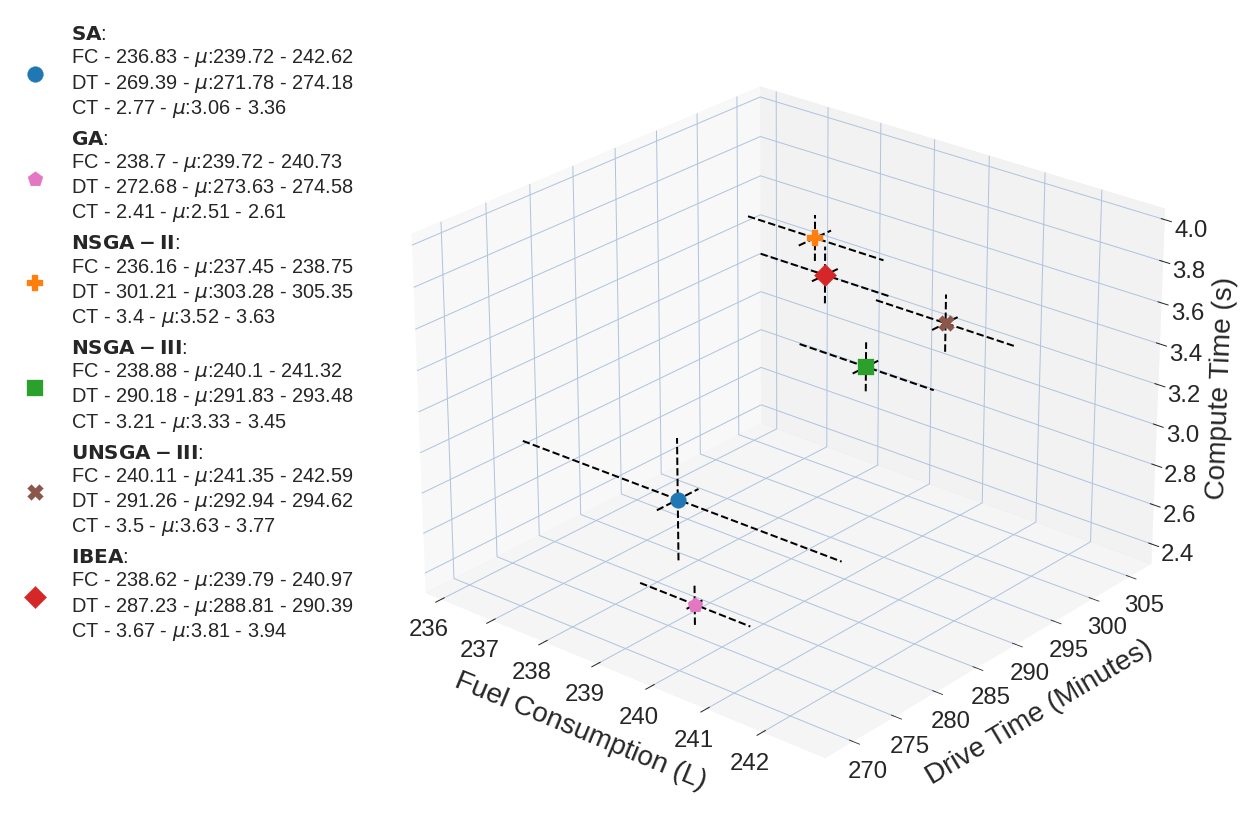

In [316]:
algorithms = [SA_best, GA_best, NSGA2_best, NSGA3_best, UNSGA3_best, IBEA_best]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_3d_minmax(algorithms, labels)
plt.legend(bbox_to_anchor=(0, 1))
ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
ax.set_zlabel("Compute Time (s)", labelpad=16)
ax.view_init(elev=25,azim=-50)
#plt.tight_layout(pad=2)
plt.show()

In [164]:
fig.savefig("{}/confidence_plot_3d_mixed_pop.pdf".format(imgs_path), bbox_inches='tight')

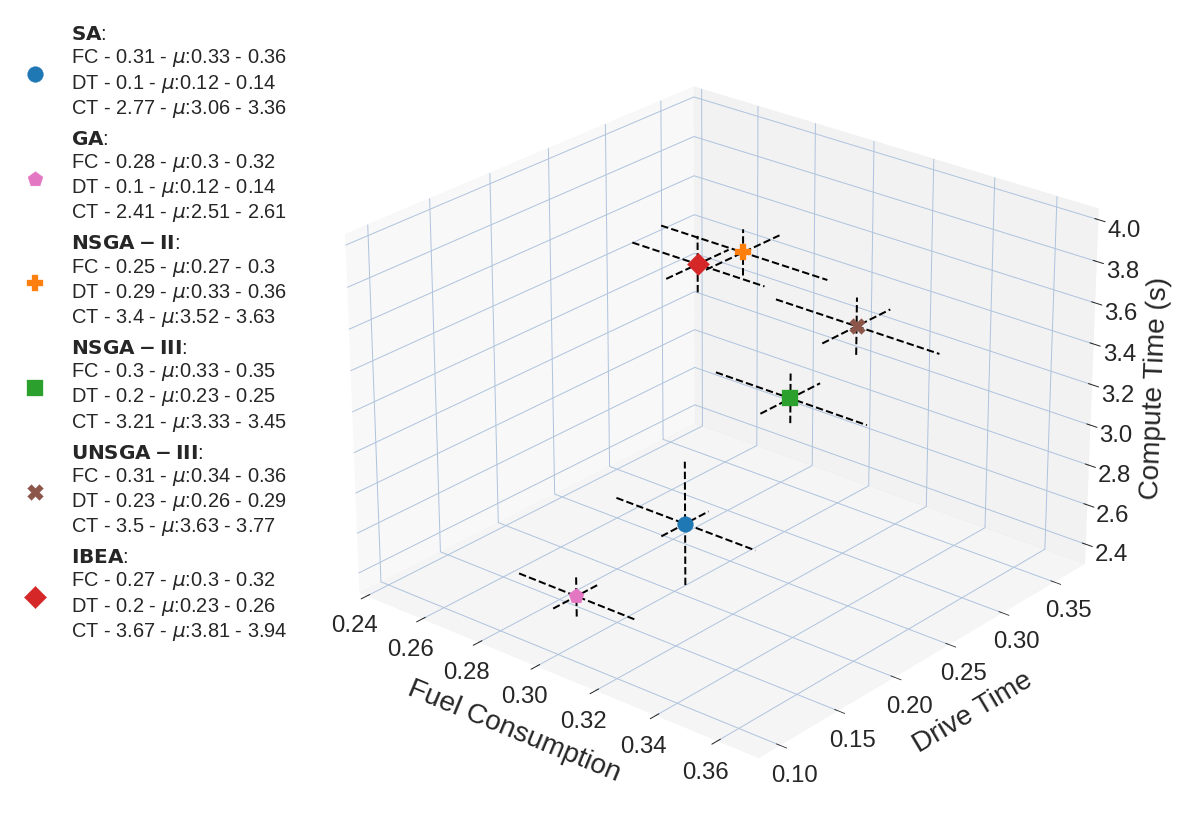

In [315]:
algorithms = [SA_best, GA_best, NSGA2_best, NSGA3_best, UNSGA3_best, IBEA_best]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_3d_minmax_scaled(algorithms, labels)
plt.legend(bbox_to_anchor=(0, 1))
ax.set_xlabel("Fuel Consumption",labelpad=24)
ax.set_ylabel("Drive Time",labelpad=24)
ax.set_zlabel("Compute Time (s)", labelpad=16)
ax.view_init(elev=25,azim=-50)
#plt.tight_layout(pad=2)
plt.show()

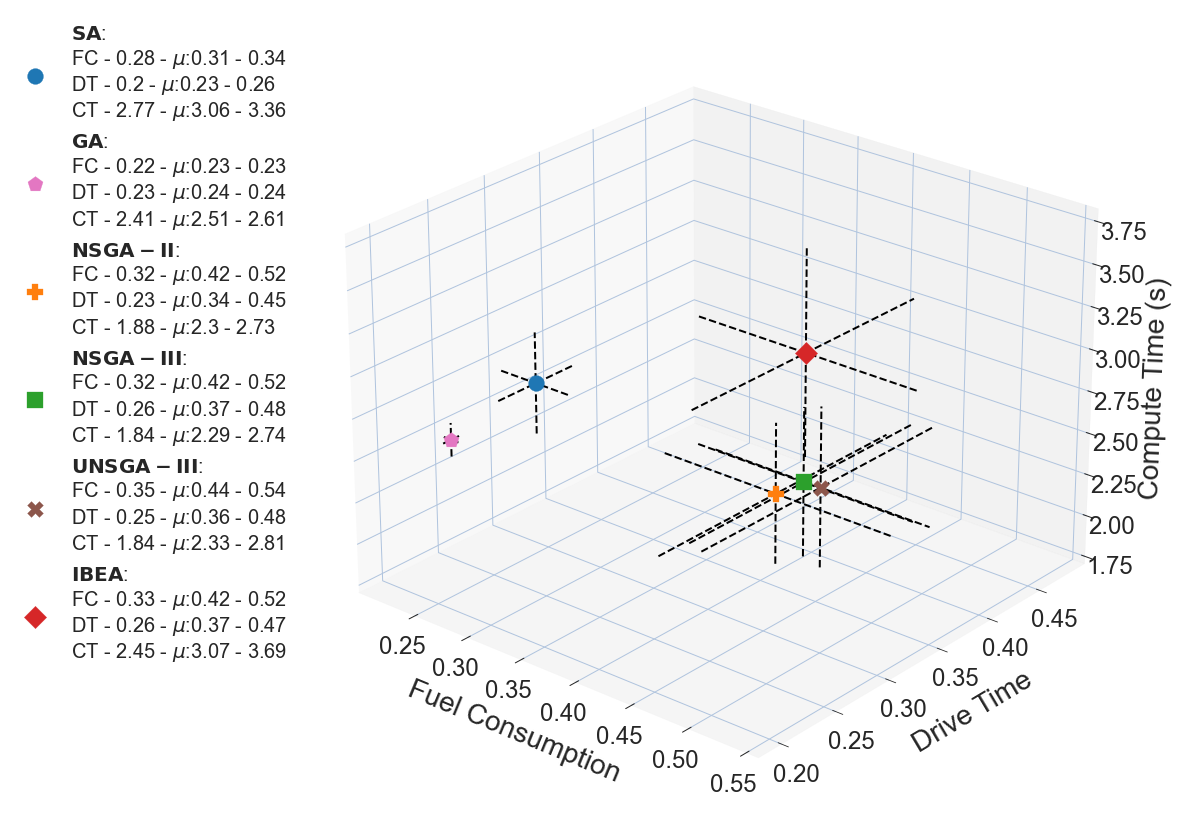

In [12]:
algorithms = [SA_data_evaluation_limited, GA_data_evaluation_limited, NSGA2_data_evaluation_limited, NSGA3_data_evaluation_limited, UNSGA3_data_evaluation_limited, IBEA_data_evaluation_limited]
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
fig, ax = plot_3d_minmax_scaled(algorithms, labels)
plt.legend(bbox_to_anchor=(0, 1))
ax.set_xlabel("Fuel Consumption",labelpad=24)
ax.set_ylabel("Drive Time",labelpad=24)
ax.set_zlabel("Compute Time (s)", labelpad=16)
ax.view_init(elev=25,azim=-50)
#plt.tight_layout(pad=2)
plt.show()